16.3 实例：使用Estimator预定义模型

这节我们用Estimator的预定义模型来解决手写10个数字问题，数据集为MNIST。

1）下载并读取数据

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tf.logging.set_verbosity(tf.logging.INFO)
#读取数据，为避免网络问题，可以先将数据下载到当前MNIST_data目录下
mnist = input_data.read_data_sets("./MNIST_data/", one_hot=False)

# 定义训练使用的输入特征列。
feature_columns = [tf.feature_column.numeric_column("image", shape=[784])]



Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


（2）实例化Estimator

In [2]:
# 创建两个隐含层,节点数分别为200、50
estimator = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                       hidden_units=[200,50],                                      
                                       optimizer=tf.train.AdamOptimizer(1e-4),
                                       n_classes=10,
                                       dropout=0.2,
                                       model_dir="model_dir")


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model_dir', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


（3）训练模型

In [4]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"image": mnist.train.images},
      y=mnist.train.labels.astype(np.int32),
      num_epochs=None,
      batch_size=128,
      shuffle=True)

estimator.train(input_fn=train_input_fn, steps=20000)


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into model_dir/model.ckpt.
INFO:tensorflow:loss = 302.131, step = 1
INFO:tensorflow:global_step/sec: 76.0175
INFO:tensorflow:loss = 192.091, step = 101 (1.320 sec)
INFO:tensorflow:global_step/sec: 76.452
INFO:tensorflow:loss = 120.149, step = 201 (1.308 sec)
INFO:tensorflow:global_step/sec: 77.384
INFO:tensorflow:loss = 100.273, step = 301 (1.291 sec)
INFO:tensorflow:global_step/sec: 79.1762
INFO:tensorflow:loss = 98.3329, step = 401 (1.265 sec)
INFO:tensorflow:global_step/sec: 80.919
INFO:tensorflow:loss = 66.3525, step = 501 (1.236 sec)
INFO:tensorflow:global_step/sec: 80.1972
INFO:tensorflow:loss = 55.7102, step = 601 (1.246 sec)
INFO:tensorflow:global_step/sec: 77.764
INFO:tensorflow:loss = 56.7284, step = 701 (1.287 sec)
INFO:tensorflow:global_step/sec: 79.117
INFO:tensorflow:loss = 71.3866, step = 801 (1.267 sec)
INFO:tensorflow:global_step/sec: 78.3708
INFO:tensorflow:loss = 67.4666, step = 901 

（4）测试模型

In [5]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"image": mnist.test.images},
      y=mnist.test.labels.astype(np.int32),
      num_epochs=1,
      batch_size=128,
      shuffle=False)

test_results = estimator.evaluate(input_fn=test_input_fn)
accuracy_score = test_results["accuracy"]
print("\nTest Accuracy: {0:.4f}\n".format(accuracy_score))

print(test_results)


INFO:tensorflow:Starting evaluation at 2018-06-27-03:37:02
INFO:tensorflow:Restoring parameters from model_dir/model.ckpt-20000
INFO:tensorflow:Finished evaluation at 2018-06-27-03:37:03
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.9788, average_loss = 0.06891, global_step = 20000, loss = 8.72279

Test Accuracy: 0.9788

{'accuracy': 0.9788, 'average_loss': 0.06891001, 'loss': 8.7227859, 'global_step': 20000}


程序非常简洁，精度达98%左右，应该还不错

16.4 实例：使用Estimator自定义模型

（1）导入一些库及定义几个变量

In [6]:
import argparse
import os
import numpy as np
import time

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

BATCH_SIZE = 100
DATA_DIR = './MNIST_data/'
MODEL_DIR = os.path.join("./custom_model_dir",str(int(time.time())))

NUM_STEPS = 1000

tf.logging.set_verbosity(tf.logging.INFO)
print("using model dir: %s" % MODEL_DIR)


using model dir: ./custom_model_dir/1530070694


（2）定义模型函数

In [7]:
def cnn_model_fn(features, labels, mode):
  """定义模型函数"""

  # 输入层
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST图片是 28x28像素, 有一个彩色通道
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  #卷积层1
  # 32个大小为 5x5的卷积核，ReLU为激活函数。
  # 填充格式为same
  # 输入张量形状: [batch_size, 28, 28, 1]
  # 输出张量形状: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  conv1= tf.layers.batch_normalization(inputs=conv1, training=mode == tf.estimator.ModeKeys.TRAIN, name='BN1')
 # 池化层1
# 使用 2x2 大小卷积核 ，步幅为2
  # 输入张量形状: [batch_size, 28, 28, 32]
  # 输出张量形状: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # 卷积层2
  # 64个大小为 5x5的卷积核
  # 填充格式为same
  #输入张量形状: [batch_size, 14, 14, 32]
  #输出张量形状: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  #池化层2
  # 最大池化层使用大小为 2x2卷积核，步幅为 2
  #输入张量形状: [batch_size, 14, 14, 64]
  #输出张量形状: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # 把张量展平为向量
  #输入张量形状: [batch_size, 7, 7, 64]
  #输出张量形状: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # 全连接层
  # 全连接层共有 1024神经元
  #输入张量形状: [batch_size, 7 * 7 * 64]
  #输出张量形状: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name="dense1")

  # 增加一个dropout操作，保持神经元比率为0.6
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # 逻辑层
  #输入张量形状: [batch_size, 1024]
  #输出张量形状: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # 产生预测值
      "classes": tf.argmax(input=logits, axis=1),
      # 把`softmax_tensor` 添加到数据流图中，被用来记录相关日志
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  prediction_output = tf.estimator.export.PredictOutput({"classes": tf.argmax(input=logits, axis=1),
     "probabilities": tf.nn.softmax(logits, name="softmax_tensor")})

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
        export_outputs={tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: prediction_output})

  # 计算代价函数
  onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
  loss = tf.losses.softmax_cross_entropy(
      onehot_labels=onehot_labels, logits=logits)
  # Generate some summary info
  tf.summary.scalar('loss', loss)
  tf.summary.histogram('conv1', conv1)
  tf.summary.histogram('dense', dense)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())

    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # 添加评估指标
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


(3)定义读取训练数据的输入函数

In [8]:
def generate_input_fn(dataset, batch_size=BATCH_SIZE):
    def _input_fn():
        X = tf.constant(dataset.images)
        Y = tf.constant(dataset.labels, dtype=tf.int32)
        image_batch, label_batch = tf.train.shuffle_batch([X,Y],
                               batch_size=batch_size,
                               capacity=8*batch_size,
                               min_after_dequeue=4*batch_size,
                               enqueue_many=True
                              )
        return {'x': image_batch} , label_batch

    return _input_fn


（5）加载训练数据及预测数据

In [9]:
#加载训练和评估数据

mnist = input_data.read_data_sets(DATA_DIR)
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

predict_data_batch = mnist.test.next_batch(10)


Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


（6）创建Estimator

In [10]:
#创建Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir=MODEL_DIR)

# 设置预测日志
# 记录预测值
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=2000)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './custom_model_dir/1530070694', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


（7）训练模型

In [11]:
#训练模型
mnist_classifier.train(
    input_fn=generate_input_fn(mnist.train, batch_size=BATCH_SIZE),
    steps=NUM_STEPS,
    hooks=[logging_hook]
    )


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./custom_model_dir/1530070694/model.ckpt.
INFO:tensorflow:probabilities = [[ 0.17813101  0.04493942  0.02448348  0.0664119   0.08420388  0.064909
   0.05033232  0.15677786  0.17856245  0.15124871]
 [ 0.11374522  0.0033673   0.04355712  0.05594146  0.35690925  0.18629949
   0.06725534  0.0182317   0.12132526  0.03336786]
 [ 0.27906948  0.0629778   0.01588251  0.01982711  0.08707919  0.10208602
   0.00684219  0.01165158  0.02791901  0.38666514]
 [ 0.44308415  0.04374738  0.01804689  0.02070023  0.08784977  0.03303255
   0.0282712   0.01923699  0.23889402  0.06713685]
 [ 0.06094289  0.02937726  0.01713669  0.04297196  0.20445527  0.03170442
   0.01256318  0.0356194   0.23273905  0.33248985]
 [ 0.24763039  0.20830308  0.1309119   0.03167938  0.09013233  0.07625874
   0.03084239  0.10888833  0.02563771  0.04971572]
 [ 0.22500195  0.01087402  0.07220987  0.07720312  0.0301585   0.07186558
   0.1597646  

（8）测试模型

In [13]:
#测试模型并打印结果
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)


INFO:tensorflow:Starting evaluation at 2018-06-27-04:00:14
INFO:tensorflow:Restoring parameters from ./custom_model_dir/1530070694/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-06-27-04:00:35
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9763, global_step = 1000, loss = 1.761
{'accuracy': 0.9763, 'loss': 1.7610019, 'global_step': 1000}


这里循环1000次，精度接近98%左右

（9）保存模型

In [14]:
def serving_input_receiver_fn():
    feature_tensor = tf.placeholder(tf.float32, [None, 784])
    return tf.estimator.export.ServingInputReceiver({'x': feature_tensor}, {'x': feature_tensor})
exported_model_dir = mnist_classifier.export_savedmodel(MODEL_DIR, serving_input_receiver_fn)
decoded_model_dir = exported_model_dir.decode("utf-8")


INFO:tensorflow:Restoring parameters from ./custom_model_dir/1530070694/model.ckpt-1000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./custom_model_dir/1530070694/1530072109/saved_model.pb'


（10）可视化结果

In [15]:
!tensorboard --logdir=$MODEL_DIR

W0627 12:02:45.178663 Reloader tf_logging.py:86] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0627 12:02:45.794696 Reloader tf_logging.py:86] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
TensorBoard 0.1.5 at http://master:6006 (Press CTRL+C to quit) ^C



16.6实例：Keras实现序列式模型

第1步：导入需要的库，构造数据

Using TensorFlow backend.


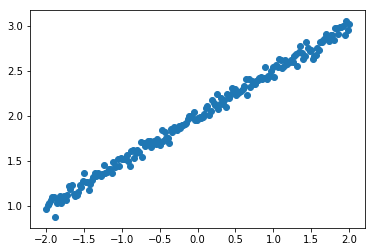

In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
%matplotlib inline

#构造数据
X = np.linspace(-2, 2, 200)
np.random.shuffle(X)    # randomize the data
#添加一些噪音数据
Y = 0.5 * X + 2 + np.random.normal(0, 0.05, (200, ))

# 显示输入数据
plt.scatter(X, Y)
plt.show()


把200份数据划分为训练数据、测试数据

In [17]:
X_train, Y_train = X[:160], Y[:160]     # first 160 data points
X_test, Y_test = X[160:], Y[160:]       # last 40 data points


第2步 构造模型

In [18]:
# 创建序列实例
model = Sequential()
model.add(Dense(units=1,activation='relu', input_dim=1))


第3步 编译模型

In [19]:
# 选择代价函数及优化器
model.compile(loss='mse', optimizer='sgd')


第4步 训练模型

In [20]:
model.fit(X_train, Y_train, epochs=100,verbose=0, batch_size=64,)

第5步 测试模型

In [21]:
# test
print('\nTesting ------------')
cost = model.evaluate(X_test, Y_test, batch_size=40)
print('test cost:', cost)
W, b = model.layers[0].get_weights()
print('Weights=', W, '\nbiases=', b)



Testing ------------
40/40 [==============================] - 0s 254us/step
test cost: 0.0020361226052
Weights= [[ 0.50184911]] 
biases= [ 1.98979783]


可视化结果：

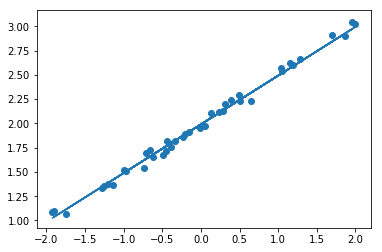

In [22]:
# plotting the prediction
Y_pred = model.predict(X_test)
plt.scatter(X_test, Y_test)
plt.plot(X_test, Y_pred)
plt.show()


16.7.1利用TFLearn解决线性回归问题

In [23]:
import tflearn

# 用于回归预测的数据
X = [3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,7.042,10.791,5.313,7.997,5.654,9.27,3.1]
Y = [1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,2.827,3.465,1.65,2.904,2.42,2.94,1.3]

# 定义线性回归模型
input_ = tflearn.input_data(shape=[None])
linear = tflearn.single_unit(input_)
regression = tflearn.regression(linear, optimizer='sgd', loss='mean_square',
                                metric='R2', learning_rate=0.01)
m = tflearn.DNN(regression)
m.fit(X, Y, n_epoch=1000, show_metric=True, snapshot_epoch=False)

print("\nRegression result:")
print("Y = " + str(m.get_weights(linear.W)) +
      "*X + " + str(m.get_weights(linear.b)))

print("\nTest prediction for x = 3.2, 3.3, 3.4:")
print(m.predict([3.2, 3.3, 3.4]))


Training Step: 1000  | total loss: 0.15967 | time: 0.005s
| SGD | epoch: 1000 | loss: 0.15967 - R2: 0.9692 -- iter: 17/17

Regression result:
Y = [ 0.28136745]*X + [ 0.58801121]

Test prediction for x = 3.2, 3.3, 3.4:
[ 1.48838711  1.51652384  1.54466057]


16.7.2利用TFLearn进行深度学习

In [ ]:

from __future__ import division, print_function, absolute_import  

import tflearn  
import tensorflow as tf
from tflearn.layers.core import input_data, dropout, fully_connected  
from tflearn.layers.conv import conv_2d, max_pool_2d  
from tflearn.layers.normalization import local_response_normalization  
from tflearn.layers.estimator import regression  
#加载mnist数据集（http://yann.lecun.com/exdb/mnist/）  
import tflearn.datasets.mnist as mnist  
X, Y, testX, testY = mnist.load_data(one_hot=True)  
X = X.reshape([-1, 28, 28, 1])  
testX = testX.reshape([-1, 28, 28, 1])  

tf.reset_default_graph()
network = input_data(shape=[None, 28, 28, 1], name='input')  
# 定义卷积层
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")  
# 定义最大池化层
network = max_pool_2d(network, 2)  
# 进行归一化处理
network = local_response_normalization(network)  
network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")  
network = max_pool_2d(network, 2)  
network = local_response_normalization(network)  
# 全连接操作  
network = fully_connected(network, 128, activation='tanh')  
# dropout操作  
network = dropout(network, 0.8)  
network = fully_connected(network, 256, activation='tanh')  
network = dropout(network, 0.8)  
network = fully_connected(network, 10, activation='softmax')  
# 回归操作  
network = regression(network, optimizer='adam', learning_rate=0.01,  
                     loss='categorical_crossentropy', name='target')  

# DNN操作，构建深度神经网络,训练模型
model = tflearn.DNN(network, tensorboard_verbose=0)  
model.fit({'input': X}, {'target': Y}, n_epoch=20,  
           validation_set=({'input': testX}, {'target': testY}),  
           snapshot_step=100, show_metric=True, run_id='convnet_mnist')  